Time Series Prep [30 Points]

In [1]:
import yfinance as yf


ticker_symbol = "SPTL"

start_date = "2014-01-01"
end_date = "2019-12-31"


data = yf.download(ticker_symbol, start=start_date, end=end_date)

data.to_csv("SPTL_prices_2014_2019.csv")
print(data.head())

[*********************100%%**********************]  1 of 1 completed

                 Open       High        Low   Close  Adj Close  Volume
Date                                                                  
2014-01-02  29.924999  30.070000  29.924999  30.055  23.299059   25400
2014-01-03  29.959999  30.105000  29.959999  30.035  23.283541   22000
2014-01-06  30.110001  30.270000  30.110001  30.160  23.380447    3200
2014-01-07  30.240000  30.260000  30.200001  30.260  23.457972    3800
2014-01-08  30.075001  30.184999  30.075001  30.150  23.372690   14800


In [2]:
import pandas as pd


data['Daily Returns'] = data['Close'].pct_change()
data['Daily Returns'].fillna(0, inplace=True)


rolling_window = 30  # Rolling window size


data['Volatility'] = data['Daily Returns'].rolling(window=rolling_window, min_periods=1).std()

data['Volatility'].fillna(0, inplace=True)

print(data.head())
data.to_csv("SPTL_prices_2014_2019.csv")


                 Open       High        Low   Close  Adj Close  Volume  \
Date                                                                     
2014-01-02  29.924999  30.070000  29.924999  30.055  23.299059   25400   
2014-01-03  29.959999  30.105000  29.959999  30.035  23.283541   22000   
2014-01-06  30.110001  30.270000  30.110001  30.160  23.380447    3200   
2014-01-07  30.240000  30.260000  30.200001  30.260  23.457972    3800   
2014-01-08  30.075001  30.184999  30.075001  30.150  23.372690   14800   

            Daily Returns  Volatility  
Date                                   
2014-01-02       0.000000    0.000000  
2014-01-03      -0.000665    0.000471  
2014-01-06       0.004162    0.002616  
2014-01-07       0.003316    0.002391  
2014-01-08      -0.003635    0.003160  


In [3]:
import pandas as pd


effr_data = pd.read_csv("EFFR.csv")


date_rate_data = effr_data[['Date', 'Rate (%)']]

date_rate_data.to_csv("EFFR_date_rate_2014_2019.csv", index=False)


In [4]:
import pandas as pd


sptl_data = pd.read_csv("SPTL_prices_2014_2019.csv") 
sptl_data['Date'] = pd.to_datetime(sptl_data['Date'])


effr_data = pd.read_csv("EFFR_date_rate_2014_2019.csv")  
effr_data['Date'] = pd.to_datetime(effr_data['Date'])

merged_data = pd.merge(sptl_data, effr_data, left_on='Date', right_on='Date', how='inner')


merged_data['rf'] = merged_data['Rate (%)']


merged_data['rf'] = merged_data['rf'] / 252


merged_data['rte'] =(merged_data['Daily Returns'] - merged_data['rf'])


merged_data = merged_data.dropna(subset=['rte'])


print(merged_data.head())


merged_data.to_csv("merged_data.csv", index=False)
print("Data processed successfully.")


        Date       Open       High        Low   Close  Adj Close  Volume  \
0 2014-01-02  29.924999  30.070000  29.924999  30.055  23.299059   25400   
1 2014-01-03  29.959999  30.105000  29.959999  30.035  23.283541   22000   
2 2014-01-06  30.110001  30.270000  30.110001  30.160  23.380447    3200   
3 2014-01-07  30.240000  30.260000  30.200001  30.260  23.457972    3800   
4 2014-01-08  30.075001  30.184999  30.075001  30.150  23.372690   14800   

   Daily Returns  Volatility  Rate (%)        rf       rte  
0       0.000000    0.000000      0.08  0.000317 -0.000317  
1      -0.000665    0.000471      0.08  0.000317 -0.000983  
2       0.004162    0.002616      0.08  0.000317  0.003844  
3       0.003316    0.002391      0.07  0.000278  0.003038  
4      -0.003635    0.003160      0.07  0.000278 -0.003913  
Data processed successfully.


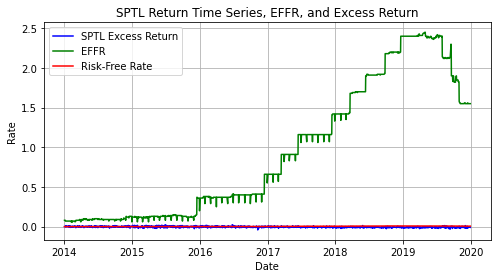

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
merged_data = pd.read_csv("merged_data.csv")
merged_data['Date'] = pd.to_datetime(merged_data['Date'])

plt.figure(figsize=(8, 4))
plt.plot(merged_data['Date'], merged_data['rte'], label='SPTL Excess Return', color='blue')


plt.plot(merged_data['Date'], merged_data['Rate (%)'], label='EFFR', color='green')


plt.plot(merged_data['Date'], merged_data['rf'], label='Risk-Free Rate', color='red')

plt.title('SPTL Return Time Series, EFFR, and Excess Return')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()
plt.grid(True)
plt.show()


Trading Strategies [45 Points]

Momentum Strategy

In [9]:
import pandas as pd


data = pd.read_csv("merged_data.csv")
# Define initial capital and leverage
V0 = 200000
L = 10

# Calculate the leveraged book size
book_size = V0 * L

# Calculate excess return
data['Excess_Return'] = (data['Close'].diff() / data['Close']) - data['rf']

data['Date'] = pd.to_datetime(data['Date'])
# Initialize positions and signals
data['theta'] = 0
data['Signal'] = 'Hold'

# Momentum strategy
for i in range(1, len(data)):
    if data['Excess_Return'][i] > 0:
        data.at[i, 'theta'] = min(book_size, data.at[i-1, 'theta'] + V0)
        data.at[i, 'Signal'] = 'Buy'
    elif data['Excess_Return'][i] < 0:
        data.at[i, 'theta'] = max(-book_size, data.at[i-1, 'theta'] - V0)
        data.at[i, 'Signal'] = 'Sell'
    else:
        data.at[i, 'θ'] = data.at[i-1, 'theta']
        data.at[i, 'Signal'] = 'Hold'

# Calculate PnL
data['PnL'] = data['Excess_Return'] * data['theta']

# Split data into training and test sets
train_size = int(0.7 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]

# Print head for training data
print("Training Data:")
print(train_data.head())

# Print head for test data
print("\nTest Data:")
print(test_data.head())

train_data.to_csv("train_data_momentum.csv", index=False)
test_data.to_csv("test_data_momentum.csv", index=False)

print("Data processed successfully.")


Training Data:
        Date       Open       High        Low   Close  Adj Close  Volume  \
0 2014-01-02  29.924999  30.070000  29.924999  30.055  23.299059   25400   
1 2014-01-03  29.959999  30.105000  29.959999  30.035  23.283541   22000   
2 2014-01-06  30.110001  30.270000  30.110001  30.160  23.380447    3200   
3 2014-01-07  30.240000  30.260000  30.200001  30.260  23.457972    3800   
4 2014-01-08  30.075001  30.184999  30.075001  30.150  23.372690   14800   

   Daily Returns  Volatility  Rate (%)        rf       rte  Excess_Return  \
0       0.000000    0.000000      0.08  0.000317 -0.000317            NaN   
1      -0.000665    0.000471      0.08  0.000317 -0.000983      -0.000983   
2       0.004162    0.002616      0.08  0.000317  0.003844       0.003827   
3       0.003316    0.002391      0.07  0.000278  0.003038       0.003027   
4      -0.003635    0.003160      0.07  0.000278 -0.003913      -0.003926   

    theta Signal         PnL  
0       0   Hold         NaN  
1 -

Momentum Strategy VS Buy and hold Strategy

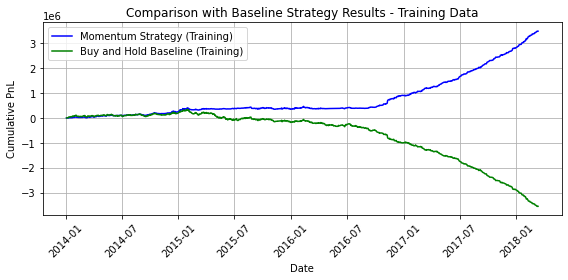

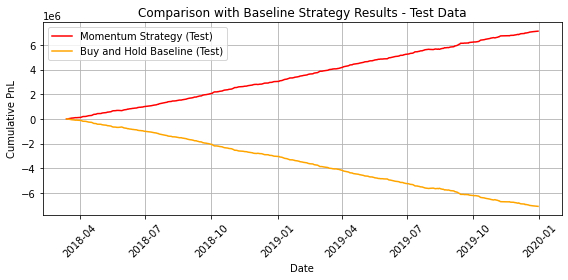

Data processed successfully.


In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv("merged_data.csv")

# Define initial capital and leverage
V0 = 200000
L = 10

# Calculate the leveraged book size
book_size = V0 * L

# Calculate excess return
data['Excess_Return'] = (data['Close'].diff() / data['Close']) - data['rf']

# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Initialize positions and signals for momentum strategy
data['theta_momentum'] = 0
data['Signal_momentum'] = 'Hold'

# Momentum strategy
for i in range(1, len(data)):
    if data['Excess_Return'][i] > 0:
        data.at[i, 'theta_momentum'] = min(book_size, data.at[i-1, 'theta_momentum'] + V0)
        data.at[i, 'Signal_momentum'] = 'Buy'
    elif data['Excess_Return'][i] < 0:
        data.at[i, 'theta_momentum'] = max(-book_size, data.at[i-1, 'theta_momentum'] - V0)
        data.at[i, 'Signal_momentum'] = 'Sell'
    else:
        data.at[i, 'theta_momentum'] = data.at[i-1, 'theta_momentum']
        data.at[i, 'Signal_momentum'] = 'Hold'

# Calculate PnL for momentum strategy
data['PnL_momentum'] = data['Excess_Return'] * data['theta_momentum']

# Initialize positions and signals for buy and hold baseline strategy
data['theta_baseline'] = book_size
data['Signal_baseline'] = 'Buy'

# Calculate PnL for buy and hold baseline strategy
data['PnL_baseline'] = data['Excess_Return'] * data['theta_baseline']

# Split data into training and test sets
train_size = int(0.7 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]

# Plot PnL for momentum strategy and buy and hold baseline strategy for training data
plt.figure(figsize=(8, 4))
plt.plot(train_data['Date'], train_data['PnL_momentum'].cumsum(), label='Momentum Strategy (Training)', color='blue')
plt.plot(train_data['Date'], train_data['PnL_baseline'].cumsum(), label='Buy and Hold Baseline (Training)', color='green')
plt.title('Comparison with Baseline Strategy Results - Training Data')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('plot2.png')
plt.show()

# Plot PnL for momentum strategy and buy and hold baseline strategy for test data
plt.figure(figsize=(8, 4))
plt.plot(test_data['Date'], test_data['PnL_momentum'].cumsum(), label='Momentum Strategy (Test)', color='red')
plt.plot(test_data['Date'], test_data['PnL_baseline'].cumsum(), label='Buy and Hold Baseline (Test)', color='orange')
plt.title('Comparison with Baseline Strategy Results - Test Data')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('plot3.png')
plt.show()

# Save processed data to CSV
train_data.to_csv("train_data_momentum.csv", index=False)
test_data.to_csv("test_data_momentum.csv", index=False)

print("Data processed successfully.")


Mean Reverting Strategy 

In [10]:
import pandas as pd

# Load the data
data = pd.read_csv("merged_data.csv")

# Define initial capital and leverage
V0 = 200000
L = 10

# Calculate the leveraged book size
book_size = V0 * L

# Calculate excess return
data['Excess_Return'] = (data['Close'].diff() / data['Close']) - data['rf']

data['Date'] = pd.to_datetime(data['Date'])


# Initialize positions and signals
data['theta'] = 0
data['Signal'] = 'Hold'

# Mean reverting strategy
for i in range(1, len(data)):
    if data['Close'][i] > data['Close'].rolling(window=30).mean()[i]:
        data.at[i, 'theta'] = max(-book_size, data.at[i-1, 'theta'] - V0)
        data.at[i, 'Signal'] = 'Sell'
    elif data['Close'][i] < data['Close'].rolling(window=30).mean()[i]:
        data.at[i, 'theta'] = min(book_size, data.at[i-1, 'theta'] + V0)
        data.at[i, 'Signal'] = 'Buy'
    else:
        data.at[i, 'theta'] = data.at[i-1, 'theta']
        data.at[i, 'Signal'] = 'Hold'

# Calculate PnL
data['PnL'] = data['Excess_Return'] * data['theta']

# Split data into training and test sets
train_size = int(0.7 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]

# Print head for training data
print("Training Data:")
print(train_data.head())

# Print head for test data
print("\nTest Data:")
print(test_data.head())


train_data.to_csv("train_data_mean_reverting.csv", index=False)
test_data.to_csv("test_data_mean_reverting.csv", index=False)

print("Data processed successfully.")


Training Data:
        Date       Open       High        Low   Close  Adj Close  Volume  \
0 2014-01-02  29.924999  30.070000  29.924999  30.055  23.299059   25400   
1 2014-01-03  29.959999  30.105000  29.959999  30.035  23.283541   22000   
2 2014-01-06  30.110001  30.270000  30.110001  30.160  23.380447    3200   
3 2014-01-07  30.240000  30.260000  30.200001  30.260  23.457972    3800   
4 2014-01-08  30.075001  30.184999  30.075001  30.150  23.372690   14800   

   Daily Returns  Volatility  Rate (%)        rf       rte  Excess_Return  \
0       0.000000    0.000000      0.08  0.000317 -0.000317            NaN   
1      -0.000665    0.000471      0.08  0.000317 -0.000983      -0.000983   
2       0.004162    0.002616      0.08  0.000317  0.003844       0.003827   
3       0.003316    0.002391      0.07  0.000278  0.003038       0.003027   
4      -0.003635    0.003160      0.07  0.000278 -0.003913      -0.003926   

   theta Signal  PnL  
0      0   Hold  NaN  
1      0   Hold -0.

Mean Reverting Strategy VS Buy and Hold Strategy

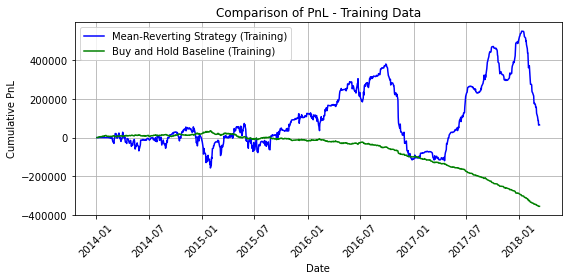

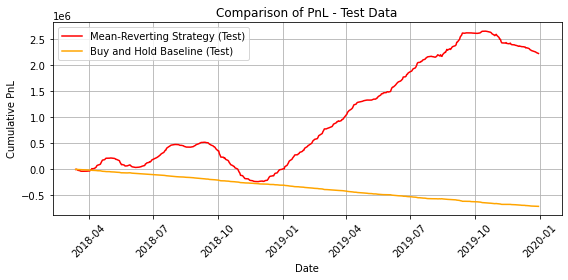

Data processed successfully.


In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv("merged_data.csv")

# Define initial capital
V0 = 200000

# Calculate the excess return
data['Excess_Return'] = (data['Close'].diff() / data['Close']) - data['rf']

data['Date'] = pd.to_datetime(data['Date'])


# Initialize positions and signals
data['theta'] = 0
data['Signal'] = 'Hold'

# Mean reverting strategy
for i in range(1, len(data)):
    if data['Close'][i] > data['Close'].rolling(window=30).mean()[i]:
        data.at[i, 'theta'] = max(-book_size, data.at[i-1, 'theta'] - V0)
        data.at[i, 'Signal'] = 'Sell'
    elif data['Close'][i] < data['Close'].rolling(window=30).mean()[i]:
        data.at[i, 'theta'] = min(book_size, data.at[i-1, 'theta'] + V0)
        data.at[i, 'Signal'] = 'Buy'
    else:
        data.at[i, 'theta'] = data.at[i-1, 'theta']
        data.at[i, 'Signal'] = 'Hold'

# Calculate PnL for the mean-reverting strategy
data['PnL'] = data['Excess_Return'] * data['theta']

# Define initial capital and leverage for the Buy and Hold strategy
V0_baseline = 200000
book_size_baseline = V0_baseline

# Calculate PnL for the Buy and Hold strategy
data['PnL_baseline'] = data['Excess_Return'] * book_size_baseline

# Split data into training and test sets
train_size = int(0.7 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]

# Plot PnL for the mean-reverting strategy and the Buy and Hold strategy on training data
plt.figure(figsize=(8, 4))
plt.plot(train_data['Date'], train_data['PnL'].cumsum(), label='Mean-Reverting Strategy (Training)', color='blue')
plt.plot(train_data['Date'], train_data['PnL_baseline'].cumsum(), label='Buy and Hold Baseline (Training)', color='green')
plt.title('Comparison of PnL - Training Data')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('plot4.png')
plt.show()

# Plot PnL for the mean-reverting strategy and the Buy and Hold strategy on test data
plt.figure(figsize=(8, 4))
plt.plot(test_data['Date'], test_data['PnL'].cumsum(), label='Mean-Reverting Strategy (Test)', color='red')
plt.plot(test_data['Date'], test_data['PnL_baseline'].cumsum(), label='Buy and Hold Baseline (Test)', color='orange')
plt.title('Comparison of PnL - Test Data')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.savefig('plot5.png')
plt.tight_layout()
plt.show()


print("Data processed successfully.")


Trend Following Strategy

In [12]:
import pandas as pd

# Load the data
data = pd.read_csv("merged_data.csv")

# Define initial capital and leverage
V0 = 200000
L = 10

# Calculate the leveraged book size
book_size = V0 * L

# Calculate excess return
data['Excess_Return'] = (data['Close'].diff() / data['Close']) - data['rf']
data['Date'] = pd.to_datetime(data['Date'])


# Initialize positions and signals
data['theta'] = 0
data['Signal'] = 'Hold'

# Trend following strategy
for i in range(1, len(data)):
    if data['Close'][i] > data['Close'][i-1]:
        data.at[i, 'theta'] = min(book_size, data.at[i-1, 'theta'] + V0)
        data.at[i, 'Signal'] = 'Buy'
    elif data['Close'][i] < data['Close'][i-1]:
        data.at[i, 'theta'] = max(-book_size, data.at[i-1, 'theta'] - V0)
        data.at[i, 'Signal'] = 'Sell'
    else:
        data.at[i, 'theta'] = data.at[i-1, 'theta']
        data.at[i, 'Signal'] = 'Hold'

# Calculate PnL
data['PnL'] = data['Excess_Return'] * data['theta']

# Split data into training and test sets
train_size = int(0.7 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]

# Print head for training data
print("Training Data:")
print(train_data.head())

# Print head for test data
print("\nTest Data:")
print(test_data.head())


train_data.to_csv("train_data_trend_following.csv", index=False)
test_data.to_csv("test_data_trend_following.csv", index=False)

print("Data processed successfully.")


Training Data:
        Date       Open       High        Low   Close  Adj Close  Volume  \
0 2014-01-02  29.924999  30.070000  29.924999  30.055  23.299059   25400   
1 2014-01-03  29.959999  30.105000  29.959999  30.035  23.283541   22000   
2 2014-01-06  30.110001  30.270000  30.110001  30.160  23.380447    3200   
3 2014-01-07  30.240000  30.260000  30.200001  30.260  23.457972    3800   
4 2014-01-08  30.075001  30.184999  30.075001  30.150  23.372690   14800   

   Daily Returns  Volatility  Rate (%)        rf       rte  Excess_Return  \
0       0.000000    0.000000      0.08  0.000317 -0.000317            NaN   
1      -0.000665    0.000471      0.08  0.000317 -0.000983      -0.000983   
2       0.004162    0.002616      0.08  0.000317  0.003844       0.003827   
3       0.003316    0.002391      0.07  0.000278  0.003038       0.003027   
4      -0.003635    0.003160      0.07  0.000278 -0.003913      -0.003926   

    theta Signal         PnL  
0       0   Hold         NaN  
1 -

Trend Following Strategy VS Buy and Hold Strategy

<ipython-input-13-6c072be9a543>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['Cumulative_PnL_Trend_Following'] = train_data['PnL'].cumsum()
<ipython-input-13-6c072be9a543>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['Cumulative_PnL_Trend_Following'] = test_data['PnL'].cumsum()
<ipython-input-13-6c072be9a543>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

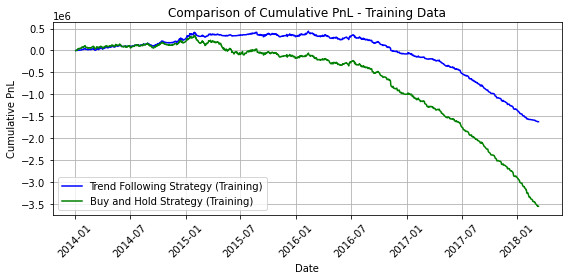

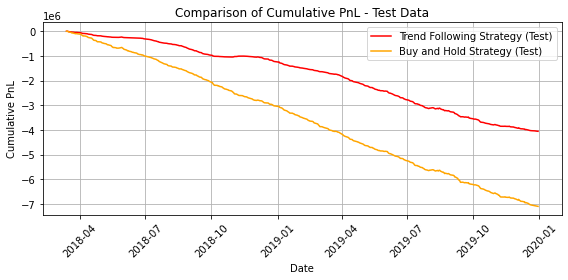

In [13]:
import matplotlib.pyplot as plt

# Calculate cumulative PnL for trend-following strategy
train_data['Cumulative_PnL_Trend_Following'] = train_data['PnL'].cumsum()
test_data['Cumulative_PnL_Trend_Following'] = test_data['PnL'].cumsum()

# Calculate cumulative PnL for Buy and Hold Strategy
train_data['Cumulative_PnL_Buy_Hold'] = (train_data['Excess_Return'] * book_size).cumsum()
test_data['Cumulative_PnL_Buy_Hold'] = (test_data['Excess_Return'] * book_size).cumsum()

# Plot cumulative PnL for training data
plt.figure(figsize=(8, 4))
plt.plot(train_data['Date'], train_data['Cumulative_PnL_Trend_Following'], label='Trend Following Strategy (Training)', color='blue')
plt.plot(train_data['Date'], train_data['Cumulative_PnL_Buy_Hold'], label='Buy and Hold Strategy (Training)', color='green')
plt.title('Comparison of Cumulative PnL - Training Data')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('plot6.png')
plt.show()

# Plot cumulative PnL for test data
plt.figure(figsize=(8, 4))
plt.plot(test_data['Date'], test_data['Cumulative_PnL_Trend_Following'], label='Trend Following Strategy (Test)', color='red')
plt.plot(test_data['Date'], test_data['Cumulative_PnL_Buy_Hold'], label='Buy and Hold Strategy (Test)', color='orange')
plt.title('Comparison of Cumulative PnL - Test Data')
plt.xlabel('Date')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('plot7.png')
plt.show()


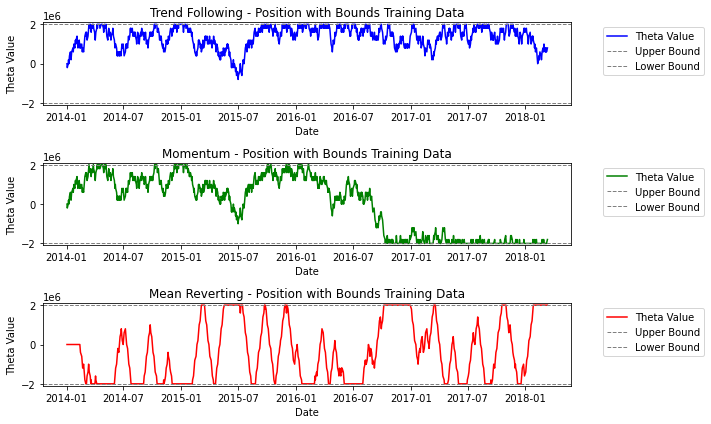

In [14]:
#Plot the position of the strategies t together with the upper and lower bounds
import pandas as pd
import matplotlib.pyplot as plt

# Load datasets
train_data_trend = pd.read_csv("train_data_trend_following.csv")
train_data_momentum = pd.read_csv("train_data_momentum.csv")
train_data_mean_reverting = pd.read_csv("train_data_mean_reverting.csv")

# Extract theta column for each strategy
theta_trend = train_data_trend['theta']
theta_momentum = train_data_momentum['theta']
theta_mean_reverting = train_data_mean_reverting['theta']

# Extract dates
dates = pd.to_datetime(train_data_trend['Date'])  # Assuming 'Date' column contains dates

# Initial capital and leverage
V0 = 200000  # Initial capital
L = 10  # Leverage
upper_bound = (V0 * L)
lower_bound = (-V0 * L)

# Plotting
plt.figure(figsize=(10, 6))  # Adjust the figure size

# Plot theta values for Trend Following strategy
plt.subplot(3, 1, 1)
plt.plot(dates, theta_trend, color='blue', label='Theta Value')
plt.axhline(upper_bound, linestyle='--', color='grey', linewidth=1, label='Upper Bound')
plt.axhline(lower_bound, linestyle='--', color='grey', linewidth=1, label='Lower Bound')
plt.ylim(lower_bound * 1.05, upper_bound * 1.05)
plt.xlabel('Date')
plt.ylabel('Theta Value')
plt.title('Trend Following - Position with Bounds Training Data')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

# Plot theta values for Momentum strategy
plt.subplot(3, 1, 2)
plt.plot(dates, theta_momentum, color='green', label='Theta Value')
plt.axhline(upper_bound, linestyle='--', color='grey', linewidth=1, label='Upper Bound')
plt.axhline(lower_bound, linestyle='--', color='grey', linewidth=1, label='Lower Bound')
plt.ylim(lower_bound * 1.05, upper_bound * 1.05)
plt.xlabel('Date')
plt.ylabel('Theta Value')
plt.title('Momentum - Position with Bounds Training Data')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

# Plot theta values for Mean Reverting strategy
plt.subplot(3, 1, 3)
plt.plot(dates, theta_mean_reverting, color='red', label='Theta Value')
plt.axhline(upper_bound, linestyle='--', color='grey', linewidth=1, label='Upper Bound')
plt.axhline(lower_bound, linestyle='--', color='grey', linewidth=1, label='Lower Bound')
plt.ylim(lower_bound * 1.05, upper_bound * 1.05)
plt.xlabel('Date')
plt.ylabel('Theta Value')
plt.title('Mean Reverting - Position with Bounds Training Data')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig('positions_with_bounds_subplots.png')  # Save the plot to a file
plt.show()


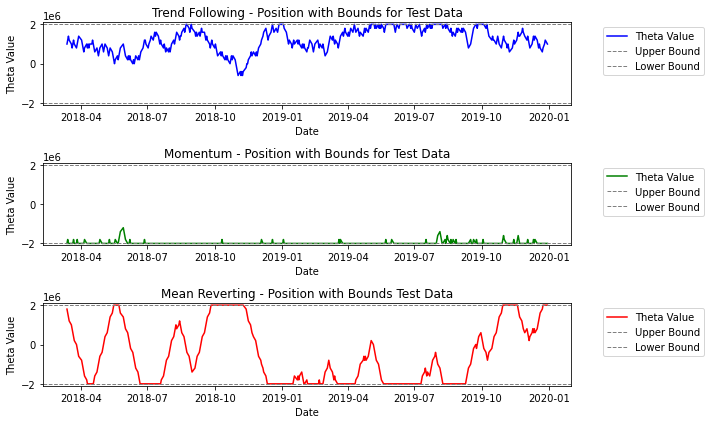

In [15]:
#Plot the position of the strategies t together with the upper and lower bounds
import pandas as pd
import matplotlib.pyplot as plt

# Load datasets
test_data_trend = pd.read_csv("test_data_trend_following.csv")
test_data_momentum = pd.read_csv("test_data_momentum.csv")
test_data_mean_reverting = pd.read_csv("test_data_mean_reverting.csv")

# Extract theta column for each strategy
theta_trend = test_data_trend['theta']
theta_momentum = test_data_momentum['theta']
theta_mean_reverting = test_data_mean_reverting['theta']

# Extract dates
dates = pd.to_datetime(test_data_trend['Date'])  # Assuming 'Date' column contains dates

# Initial capital and leverage
V0 = 200000  # Initial capital
L = 10  # Leverage
upper_bound = (V0 * L)
lower_bound = (-V0 * L)

# Plotting
plt.figure(figsize=(10, 6))  # Adjust the figure size

# Plot theta values for Trend Following strategy
plt.subplot(3, 1, 1)
plt.plot(dates, theta_trend, color='blue', label='Theta Value')
plt.axhline(upper_bound, linestyle='--', color='grey', linewidth=1, label='Upper Bound')
plt.axhline(lower_bound, linestyle='--', color='grey', linewidth=1, label='Lower Bound')
plt.ylim(lower_bound * 1.05, upper_bound * 1.05)
plt.xlabel('Date')
plt.ylabel('Theta Value')
plt.title('Trend Following - Position with Bounds for Test Data')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

# Plot theta values for Momentum strategy
plt.subplot(3, 1, 2)
plt.plot(dates, theta_momentum, color='green', label='Theta Value')
plt.axhline(upper_bound, linestyle='--', color='grey', linewidth=1, label='Upper Bound')
plt.axhline(lower_bound, linestyle='--', color='grey', linewidth=1, label='Lower Bound')
plt.ylim(lower_bound * 1.05, upper_bound * 1.05)
plt.xlabel('Date')
plt.ylabel('Theta Value')
plt.title('Momentum - Position with Bounds for Test Data')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

# Plot theta values for Mean Reverting strategy
plt.subplot(3, 1, 3)
plt.plot(dates, theta_mean_reverting, color='red', label='Theta Value')
plt.axhline(upper_bound, linestyle='--', color='grey', linewidth=1, label='Upper Bound')
plt.axhline(lower_bound, linestyle='--', color='grey', linewidth=1, label='Lower Bound')
plt.ylim(lower_bound * 1.05, upper_bound * 1.05)
plt.xlabel('Date')
plt.ylabel('Theta Value')
plt.title('Mean Reverting - Position with Bounds Test Data')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()  # Adjust layout to prevent overlap
plt.savefig('positions_with_bounds_subplots.png')  # Save the plot to a file
plt.show()


In [16]:
#Q2 bb Calulate Turnover in dollars and Turnover in units for training set
import pandas as pd

# Load the training and testing data for each strategy
train_data_trend = pd.read_csv("train_data_trend_following.csv")
train_data_momentum = pd.read_csv("train_data_momentum.csv")
train_data_mean_reverting = pd.read_csv("train_data_mean_reverting.csv")

test_data_trend = pd.read_csv("test_data_trend_following.csv")
test_data_momentum = pd.read_csv("test_data_momentum.csv")
test_data_mean_reverting = pd.read_csv("test_data_mean_reverting.csv")

# Define initial capital and leverage
V0 = 200000
L = 10

# Calculate the leveraged book size
book_size = V0 * L

# Function to calculate turnover in dollar value traded over time
def calculate_turnover_dollars(data):
    turnover_dollars = data['theta'].diff().abs().fillna(0)
    return turnover_dollars.sum()  # Sum up the absolute values

# Function to calculate turnover in number of units traded over time
def calculate_turnover_units(data):
    turnover_units = abs((data['theta'].shift(-1) / data['Close'].shift(-1)) - (data['theta'] / data['Close']))
    return turnover_units.sum()  # Sum up the absolute values

# Calculate turnover for each strategy in training data
turnover_dollars_trend_train = calculate_turnover_dollars(train_data_trend)
turnover_units_trend_train = calculate_turnover_units(train_data_trend)

turnover_dollars_momentum_train = calculate_turnover_dollars(train_data_momentum)
turnover_units_momentum_train = calculate_turnover_units(train_data_momentum)

turnover_dollars_mean_reverting_train = calculate_turnover_dollars(train_data_mean_reverting)
turnover_units_mean_reverting_train = calculate_turnover_units(train_data_mean_reverting)

# Print turnover for training data of each strategy
print("Training Data - Trend Following:")
print("Turnover (Dollars):", turnover_dollars_trend_train)
print("Turnover (Units):", turnover_units_trend_train)

print("\nTraining Data - Momentum Trading:")
print("Turnover (Dollars):", turnover_dollars_momentum_train)
print("Turnover (Units):", turnover_units_momentum_train)

print("\nTraining Data - Mean Reverting:")
print("Turnover (Dollars):", turnover_dollars_mean_reverting_train)
print("Turnover (Units):", turnover_units_mean_reverting_train)

# Calculate turnover for each strategy in testing data
turnover_dollars_trend_test = calculate_turnover_dollars(test_data_trend)
turnover_units_trend_test = calculate_turnover_units(test_data_trend)

turnover_dollars_momentum_test = calculate_turnover_dollars(test_data_momentum)
turnover_units_momentum_test = calculate_turnover_units(test_data_momentum)

turnover_dollars_mean_reverting_test = calculate_turnover_dollars(test_data_mean_reverting)
turnover_units_mean_reverting_test = calculate_turnover_units(test_data_mean_reverting)

# Print turnover for testing data of each strategy
print("\nTesting Data - Trend Following:")
print("Turnover (Dollars):", turnover_dollars_trend_test)
print("Turnover (Units):", turnover_units_trend_test)

print("\nTesting Data - Momentum Trading:")
print("Turnover (Dollars):", turnover_dollars_momentum_test)
print("Turnover (Units):", turnover_units_momentum_test)

print("\nTesting Data - Mean Reverting:")
print("Turnover (Dollars):", turnover_dollars_mean_reverting_test)
print("Turnover (Units):", turnover_units_mean_reverting_test)


Training Data - Trend Following:
Turnover (Dollars): 194000000.0
Turnover (Units): 5296922.570538735

Training Data - Momentum Trading:
Turnover (Dollars): 169400000.0
Turnover (Units): 4774584.360942765

Training Data - Mean Reverting:
Turnover (Dollars): 123200000.0
Turnover (Units): 3581096.9269920755

Testing Data - Trend Following:
Turnover (Dollars): 80800000.0
Turnover (Units): 2197375.8470139145

Testing Data - Momentum Trading:
Turnover (Dollars): 17200000.0
Turnover (Units): 575571.3937364661

Testing Data - Mean Reverting:
Turnover (Dollars): 52600000.0
Turnover (Units): 1505517.9433046042


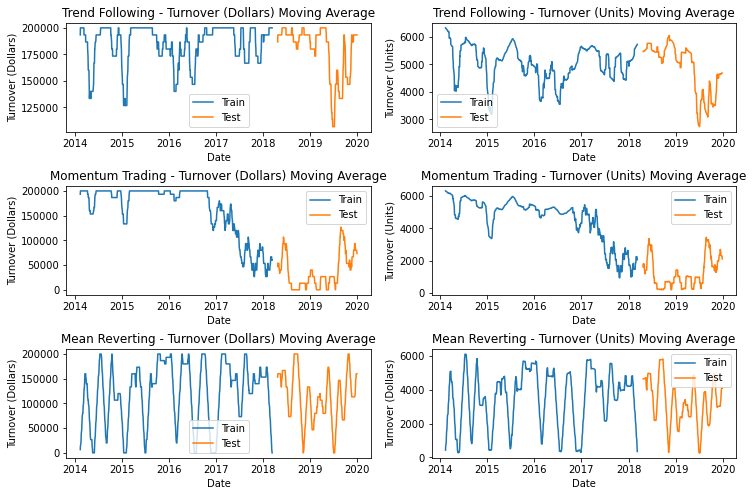

In [17]:
#Q2 bb Calulate Turnover in dollars and Turnover in units for test set
import pandas as pd
import matplotlib.pyplot as plt

# Load the training and testing data for each strategy
train_data_trend = pd.read_csv("train_data_trend_following.csv")
train_data_momentum = pd.read_csv("train_data_momentum.csv")
train_data_mean_reverting = pd.read_csv("train_data_mean_reverting.csv")

test_data_trend = pd.read_csv("test_data_trend_following.csv")
test_data_momentum = pd.read_csv("test_data_momentum.csv")
test_data_mean_reverting = pd.read_csv("test_data_mean_reverting.csv")

# Define initial capital and leverage
V0 = 200000
L = 10

# Function to calculate turnover in dollar value traded over time
def calculate_turnover_dollars(data):
    turnover_dollars = data['theta'].diff().abs().fillna(0)
    return turnover_dollars

# Function to calculate turnover in number of units traded over time
def calculate_turnover_units(data):
    turnover_units = abs((data['theta'].shift(-1) / data['Close'].shift(-1)) - (data['theta'] / data['Close']))
    return turnover_units

# Calculate turnover for each strategy in training data
train_data_trend['Turnoverdollars'] = calculate_turnover_dollars(train_data_trend)
train_data_trend['Turnoverunits'] = calculate_turnover_units(train_data_trend)

train_data_momentum['Turnoverdollars'] = calculate_turnover_dollars(train_data_momentum)
train_data_momentum['Turnoverunits'] = calculate_turnover_units(train_data_momentum)

train_data_mean_reverting['Turnoverdollars'] = calculate_turnover_dollars(train_data_mean_reverting)
train_data_mean_reverting['Turnoverunits'] = calculate_turnover_units(train_data_mean_reverting)

test_data_trend['Turnoverdollars'] = calculate_turnover_dollars(test_data_trend)
test_data_trend['Turnoverunits'] = calculate_turnover_units(test_data_trend)

test_data_momentum['Turnoverdollars'] = calculate_turnover_dollars(test_data_momentum)
test_data_momentum['Turnoverunits'] = calculate_turnover_units(test_data_momentum)

test_data_mean_reverting['Turnoverdollars'] = calculate_turnover_dollars(test_data_mean_reverting)
test_data_mean_reverting['Turnoverunits'] = calculate_turnover_units(test_data_mean_reverting)

train_data_trend['Date'] = pd.to_datetime(train_data_trend['Date'])
train_data_momentum['Date'] = pd.to_datetime(train_data_momentum['Date'])
train_data_mean_reverting['Date'] = pd.to_datetime(train_data_mean_reverting['Date'])

test_data_trend['Date'] = pd.to_datetime(test_data_trend['Date'])
test_data_momentum['Date'] = pd.to_datetime(test_data_momentum['Date'])
test_data_mean_reverting['Date'] = pd.to_datetime(test_data_mean_reverting['Date'])

# Plot moving average of turnover for each strategy in training and testing data
window_size = 30

plt.figure(figsize=(12, 8))

plt.subplot(3, 2, 1)
plt.plot(train_data_trend['Date'], train_data_trend['Turnoverdollars'].rolling(window=window_size).mean(), label='Train')
plt.plot(test_data_trend['Date'], test_data_trend['Turnoverdollars'].rolling(window=window_size).mean(), label='Test')
plt.title('Trend Following - Turnover (Dollars) Moving Average')
plt.xlabel('Date')
plt.ylabel('Turnover (Dollars)')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(train_data_trend['Date'], train_data_trend['Turnoverunits'].rolling(window=window_size).mean(), label='Train')
plt.plot(test_data_trend['Date'], test_data_trend['Turnoverunits'].rolling(window=window_size).mean(), label='Test')
plt.title('Trend Following - Turnover (Units) Moving Average')
plt.xlabel('Date')
plt.ylabel('Turnover (Units)')
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(train_data_momentum['Date'], train_data_momentum['Turnoverdollars'].rolling(window=window_size).mean(), label='Train')
plt.plot(test_data_momentum['Date'], test_data_momentum['Turnoverdollars'].rolling(window=window_size).mean(), label='Test')
plt.title('Momentum Trading - Turnover (Dollars) Moving Average')
plt.xlabel('Date')
plt.ylabel('Turnover (Dollars)')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(train_data_momentum['Date'], train_data_momentum['Turnoverunits'].rolling(window=window_size).mean(), label='Train')
plt.plot(test_data_momentum['Date'], test_data_momentum['Turnoverunits'].rolling(window=window_size).mean(), label='Test')
plt.title('Momentum Trading - Turnover (Units) Moving Average')
plt.xlabel('Date')
plt.ylabel('Turnover (Units)')
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(train_data_mean_reverting['Date'], train_data_mean_reverting['Turnoverdollars'].rolling(window=window_size).mean(), label='Train')
plt.plot(test_data_mean_reverting['Date'], test_data_mean_reverting['Turnoverdollars'].rolling(window=window_size).mean(), label='Test')
plt.title('Mean Reverting - Turnover (Dollars) Moving Average')
plt.xlabel('Date')
plt.ylabel('Turnover (Dollars)')
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(train_data_mean_reverting['Date'], train_data_mean_reverting['Turnoverunits'].rolling(window=window_size).mean(), label='Train')
plt.plot(test_data_mean_reverting['Date'], test_data_mean_reverting['Turnoverunits'].rolling(window=window_size).mean(), label='Test')
plt.title('Mean Reverting - Turnover (Units) Moving Average')
plt.xlabel('Date')
plt.ylabel('Turnover (Dollars)')
plt.legend()

plt.subplots_adjust(hspace=0.5)
plt.show()

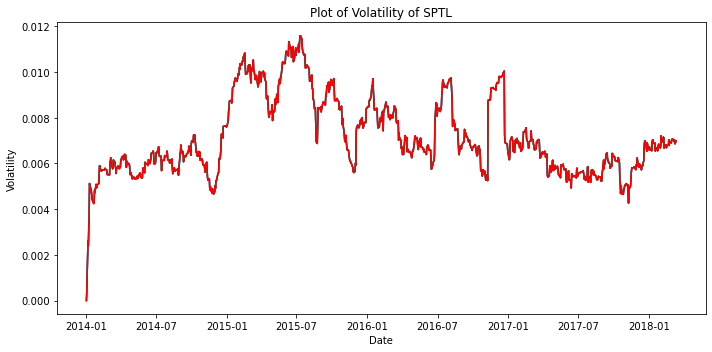

In [18]:
# Volatility plot for STPL
import pandas as pd
import matplotlib.pyplot as plt

# Load datasets
train_data_trend = pd.read_csv("train_data_trend_following.csv")
train_data_momentum = pd.read_csv("train_data_momentum.csv")
train_data_mean_reverting = pd.read_csv("train_data_mean_reverting.csv")

# Convert 'Date' column to datetime format
train_data_trend['Date'] = pd.to_datetime(train_data_trend['Date'])
train_data_momentum['Date'] = pd.to_datetime(train_data_momentum['Date'])
train_data_mean_reverting['Date'] = pd.to_datetime(train_data_mean_reverting['Date'])

# Set 'Date' column as the index
train_data_trend.set_index('Date', inplace=True)
train_data_momentum.set_index('Date', inplace=True)
train_data_mean_reverting.set_index('Date', inplace=True)

# Assuming 'Volatility' column exists in the dataset
trend_data_volatility = train_data_trend['Volatility']
momentum_data_volatility = train_data_momentum['Volatility']
mean_reverting_data_volatility = train_data_mean_reverting['Volatility']

# Plot volatility for each strategy in training data
plt.figure(figsize=(10, 5))

# Plot with date on x-axis
plt.plot(train_data_trend.index, trend_data_volatility, label='Trend Following', color='blue')
plt.plot(train_data_momentum.index, momentum_data_volatility, label='Momentum Trading', color='green')
plt.plot(train_data_mean_reverting.index, mean_reverting_data_volatility, label='Mean Reverting', color='red')

plt.title('Plot of Volatility of SPTL')
plt.xlabel('Date')
plt.ylabel('Volatility')

plt.tight_layout()
plt.show()


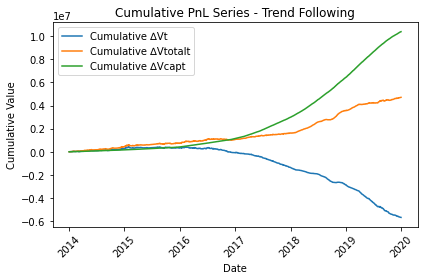

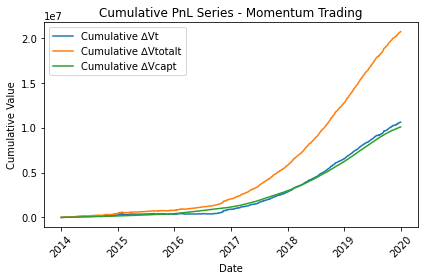

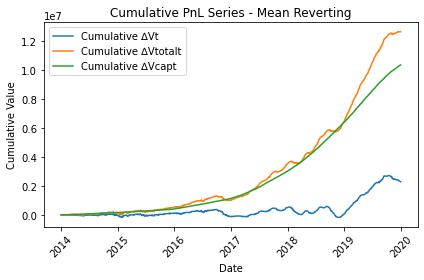

In [19]:
#Q2 c  Total Pnl series plot
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets
train_data_trend = pd.read_csv("train_data_trend_following.csv")
train_data_momentum = pd.read_csv("train_data_momentum.csv")
train_data_mean_reverting = pd.read_csv("train_data_mean_reverting.csv")

test_data_trend = pd.read_csv("test_data_trend_following.csv")
test_data_momentum = pd.read_csv("test_data_momentum.csv")
test_data_mean_reverting = pd.read_csv("test_data_mean_reverting.csv")

# Define leverage
L = 10

# Calculate initial capital
V0 = 200000

# Concatenate training and test datasets for each strategy
trend_data = pd.concat([train_data_trend, test_data_trend], ignore_index=True)
momentum_data = pd.concat([train_data_momentum, test_data_momentum], ignore_index=True)
mean_reverting_data = pd.concat([train_data_mean_reverting, test_data_mean_reverting], ignore_index=True)

# Define a function to calculate cumulative values and plot
def plot_cumulative(df, strategy_name):
    # Calculate Mt
    df['Date'] = pd.to_datetime(df['Date'])
    df['Mt'] = df['theta'].abs() / L

    # Calculate ∆Vt
    df['∆Vt'] = df['PnL']

    # Calculate ∆Vcapt
    df['∆Vcapt'] = (V0 * L - df['Mt']) * df['rf']

    # Calculate ∆Vtotalt
    df['∆Vtotalt'] = df['∆Vt'] + df['∆Vcapt']

    # Calculate cumulative values
    df['Cumulative ∆Vt'] = df['∆Vt'].cumsum()
    df['Cumulative ∆Vcapt'] = df['∆Vcapt'].cumsum()
    df['Cumulative ∆Vtotalt'] = df['∆Vtotalt'].cumsum()

    # Plot the cumulative values
    plt.figure(figsize=(6, 4))
    plt.plot(df['Date'], df['Cumulative ∆Vt'], label='Cumulative ∆Vt')
    plt.plot(df['Date'], df['Cumulative ∆Vtotalt'], label='Cumulative ∆Vtotalt')
    plt.plot(df['Date'], df['Cumulative ∆Vcapt'], label='Cumulative ∆Vcapt')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Value')
    plt.title(f'Cumulative PnL Series - {strategy_name}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot for Trend Following strategy
plot_cumulative(trend_data, 'Trend Following')

# Plot for Momentum Trading strategy
plot_cumulative(momentum_data, 'Momentum Trading')

# Plot for Mean Reverting strategy
plot_cumulative(mean_reverting_data, 'Mean Reverting')


 Performance Indicators [25 Points]

In [4]:
#Q3 a
import pandas as pd
import numpy as np

# Function to compute Sharpe Ratio
def sharpe_ratio(returns, risk_free_rate):
    mean_return = np.mean(returns)
    std_return = np.std(returns)
    return (mean_return - risk_free_rate) / std_return

# Function to compute Sortino Ratio
def sortino_ratio(returns, risk_free_rate):
    downside_returns = returns[returns < 0]
    downside_std = np.std(downside_returns)
    mean_return = np.mean(returns)
    return (mean_return - risk_free_rate) / downside_std

# Function to compute Maximum Drawdown
def maximum_drawdown(returns):
    cum_returns = np.cumsum(returns)
    drawdown = np.maximum.accumulate(cum_returns) - cum_returns
    max_drawdown = np.max(drawdown)
    return max_drawdown

# Function to compute Calmar Ratio
def calmar_ratio(returns, max_drawdown, annualized_return):
    return annualized_return / max_drawdown

# Load data
train_data = {
    "trend": train_data_trend,
    "momentum": train_data_momentum,
    "mean_reverting": train_data_mean_reverting
}

test_data = {
    "trend": test_data_trend,
    "momentum": test_data_momentum,
    "mean_reverting": test_data_mean_reverting
}

# Loop through datasets and calculate metrics
for name, data in train_data.items():
    excess_returns_train = data['PnL'].dropna()
    excess_returns_test = test_data[name]['PnL'].dropna()
    risk_free_rate_train = data['rf'].mean()
    risk_free_rate_test = test_data[name]['rf'].mean()

    # Sharpe Ratio
    sr_train = sharpe_ratio(excess_returns_train, risk_free_rate_train)
    sr_test = sharpe_ratio(excess_returns_test, risk_free_rate_test)

    # Sortino Ratio
    sortino_train = sortino_ratio(excess_returns_train, risk_free_rate_train)
    sortino_test = sortino_ratio(excess_returns_test, risk_free_rate_test)

    # Maximum Drawdown
    max_drawdown_train = maximum_drawdown(excess_returns_train)
    max_drawdown_test = maximum_drawdown(excess_returns_test)

    # Calmar Ratio
    annualized_return_train = np.mean(excess_returns_train) * 252  # Assuming 252 trading days
    annualized_return_test = np.mean(excess_returns_test) * 252
    calmar_train = calmar_ratio(excess_returns_train, max_drawdown_train, annualized_return_train)
    calmar_test = calmar_ratio(excess_returns_test, max_drawdown_test, annualized_return_test)

    print(f"Metrics for {name.capitalize()} strategy:")
    print("Training Set:")
    print(f"Sharpe Ratio: {sr_train:.2f}")
    print(f"Sortino Ratio: {sortino_train:.2f}")
    print(f"Maximum Drawdown: {max_drawdown_train:.2%}")
    print(f"Calmar Ratio: {calmar_train:.2f}")
    print("\nTest Set:")
    print(f"Sharpe Ratio: {sr_test:.2f}")
    print(f"Sortino Ratio: {sortino_test:.2f}")
    print(f"Maximum Drawdown: {max_drawdown_test:.2%}")
    print(f"Calmar Ratio: {calmar_test:.2f}")
    print("\n")


Metrics for Trend strategy:
Training Set:
Sharpe Ratio: -0.15
Sortino Ratio: -0.22
Maximum Drawdown: 206671704.44%
Calmar Ratio: -0.19

Test Set:
Sharpe Ratio: -0.93
Sortino Ratio: -1.09
Maximum Drawdown: 405569617.84%
Calmar Ratio: -0.56


Metrics for Momentum strategy:
Training Set:
Sharpe Ratio: 0.30
Sortino Ratio: 0.54
Maximum Drawdown: 10316912.04%
Calmar Ratio: 8.15

Test Set:
Sharpe Ratio: 1.23
Sortino Ratio: 2.66
Maximum Drawdown: 2750517.86%
Calmar Ratio: 144.96


Metrics for Mean_reverting strategy:
Training Set:
Sharpe Ratio: 0.01
Sortino Ratio: 0.01
Maximum Drawdown: 50019941.97%
Calmar Ratio: 0.03

Test Set:
Sharpe Ratio: 0.31
Sortino Ratio: 0.48
Maximum Drawdown: 75497164.86%
Calmar Ratio: 1.65




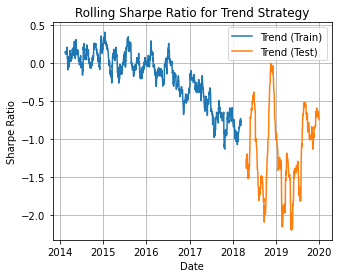

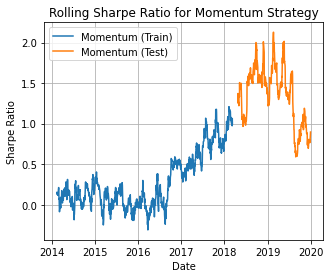

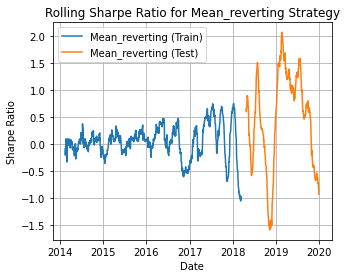

In [11]:
#Q3b
import pandas as pd
import matplotlib.pyplot as plt

# Read train data
train_data_trend = pd.read_csv("train_data_trend_following.csv", parse_dates=['Date'])
train_data_momentum = pd.read_csv("train_data_momentum.csv", parse_dates=['Date'])
train_data_mean_reverting = pd.read_csv("train_data_mean_reverting.csv", parse_dates=['Date'])

# Read test data
test_data_trend = pd.read_csv("test_data_trend_following.csv", parse_dates=['Date'])
test_data_momentum = pd.read_csv("test_data_momentum.csv", parse_dates=['Date'])
test_data_mean_reverting = pd.read_csv("test_data_mean_reverting.csv", parse_dates=['Date'])

# Define window size for rolling calculation
window = 30  # You can adjust this value as needed

# Function to calculate rolling Sharpe Ratio
def rolling_sharpe_ratio(returns, window):
    rolling_mean = returns.rolling(window=window).mean()
    rolling_std = returns.rolling(window=window).std()
    return rolling_mean / rolling_std

# Plot rolling Sharpe Ratio for each strategy in both train and test sets
for (train_data, test_data), strategy_name in zip(
        [ (train_data_trend, test_data_trend),
          (train_data_momentum, test_data_momentum),
          (train_data_mean_reverting, test_data_mean_reverting)],
        ["trend", "momentum", "mean_reverting"]):
    
    plt.figure(figsize=(5, 4))
    
    excess_returns_train = train_data['PnL'].dropna()
    excess_returns_test = test_data['PnL'].dropna()
    
    # Calculate rolling Sharpe Ratio
    rolling_sr_train = rolling_sharpe_ratio(excess_returns_train, window)
    rolling_sr_test = rolling_sharpe_ratio(excess_returns_test, window)
    
    # Plotting
    plt.plot(train_data['Date'][:-1], rolling_sr_train, label=f"{strategy_name.capitalize()} (Train)")
    plt.plot(test_data['Date'], rolling_sr_test, label=f"{strategy_name.capitalize()} (Test)")

    plt.title(f"Rolling Sharpe Ratio for {strategy_name.capitalize()} Strategy")
    plt.xlabel("Date")
    plt.ylabel("Sharpe Ratio")
    plt.legend()
    plt.grid(True)
    plt.show()

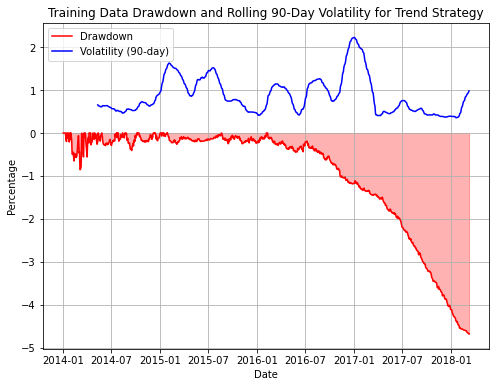

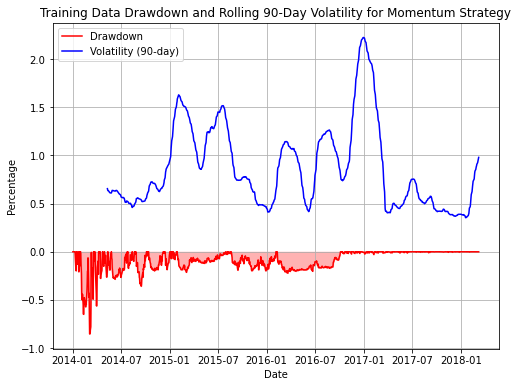

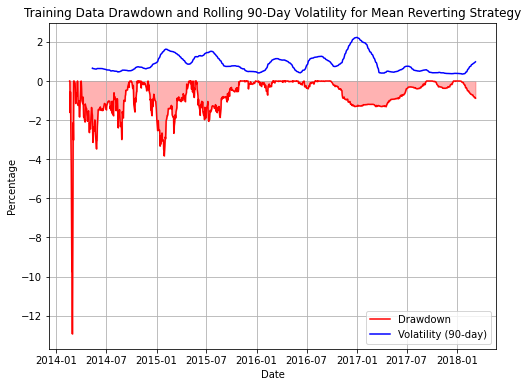

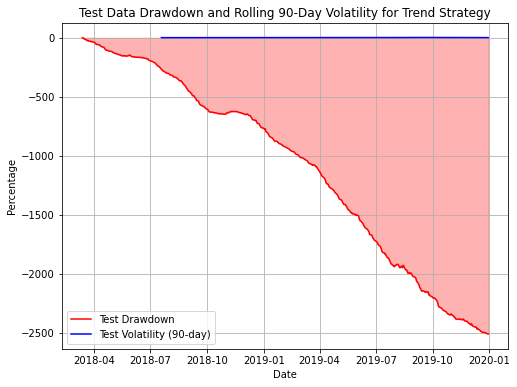

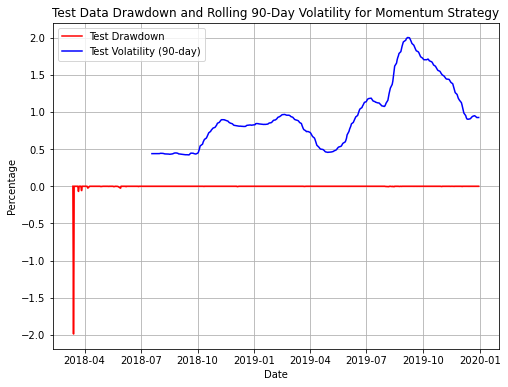

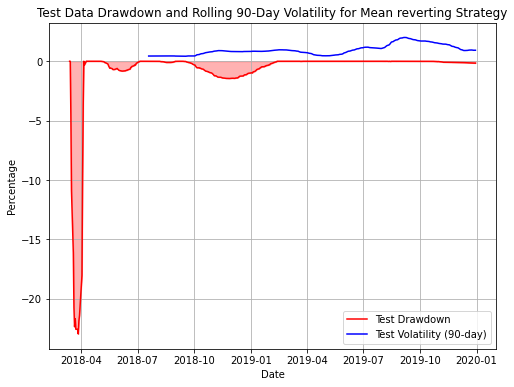

In [2]:
#Q3 c
import pandas as pd
import matplotlib.pyplot as plt

# Load data
train_data_trend = pd.read_csv("train_data_trend_following.csv")
train_data_momentum = pd.read_csv("train_data_momentum.csv")
train_data_mean_reverting = pd.read_csv("train_data_mean_reverting.csv")

test_data_trend = pd.read_csv("test_data_trend_following.csv")
test_data_momentum = pd.read_csv("test_data_momentum.csv")
test_data_mean_reverting = pd.read_csv("test_data_mean_reverting.csv")

# Function to calculate drawdown
def calculate_drawdown(returns):
    cum_returns = returns.cumsum()
    peak = cum_returns.cummax()
    drawdown = (cum_returns - peak) / peak
    return drawdown

# Function to calculate rolling volatility
def rolling_volatility(price, window):
    return price.rolling(window=window).std()

# Define window size for rolling volatility calculation
volatility_window = 90  # 90-day rolling volatility

# Plot drawdown chart with rolling volatility for each strategy separately
for name, data in [("Trend", train_data_trend), ("Momentum", train_data_momentum), ("Mean Reverting", train_data_mean_reverting)]:
    plt.figure(figsize=(8, 6))
    
    pnl = data['PnL'].dropna()
    price = data['Close']
    date = pd.to_datetime(data['Date'])  # Convert date strings to datetime objects
    
    # Ensure both date and data have the same length
    min_length = min(len(date), len(pnl))
    date = date[:min_length]
    pnl = pnl[:min_length]
    price = price[:min_length]
    
    # Calculate drawdown
    drawdown = calculate_drawdown(pnl)
    
    # Calculate rolling volatility
    rolling_vol = rolling_volatility(price, volatility_window)
    
    # Plot drawdown
    plt.plot(date, drawdown, label='Drawdown', color='red')
    plt.fill_between(date, drawdown, color='red', alpha=0.3)

    # Plot rolling volatility
    plt.plot(date, rolling_vol, label='Volatility (90-day)', color='blue')

    plt.title(f"Training Data Drawdown and Rolling 90-Day Volatility for {name} Strategy")
    plt.xlabel("Date")
    plt.ylabel("Percentage")
    plt.legend()
    plt.grid(True)
    plt.show()
    
for name, data in [("Trend", test_data_trend), ("Momentum", test_data_momentum), ("Mean Reverting", test_data_mean_reverting)]:
    plt.figure(figsize=(8, 6))
    
    test_pnl = data['PnL'].dropna()
    test_price = data['Close']
    test_date = pd.to_datetime(data['Date'])  # Convert date strings to datetime objects
    
    # Ensure both date and data have the same length
    min_length = min(len(test_date), len(test_pnl))
    test_date = test_date[:min_length]
    test_pnl = test_pnl[:min_length]
    test_price = test_price[:min_length]
    
    # Calculate drawdown for test data
    test_drawdown = calculate_drawdown(test_pnl)
    
    # Calculate rolling volatility for test data
    test_rolling_vol = rolling_volatility(test_price, volatility_window)

    plt.plot(test_date, test_drawdown, label='Test Drawdown', color='red')
    plt.fill_between(test_date, test_drawdown, color='red', alpha=0.3)
    plt.plot(test_date, test_rolling_vol, label='Test Volatility (90-day)', color='blue')

    plt.title(f"Test Data Drawdown and Rolling 90-Day Volatility for {name.capitalize()} Strategy")
    plt.xlabel("Date")
    plt.ylabel("Percentage")
    plt.legend()
    plt.grid(True)
    plt.show()
